## Check data loading

This code copies the data loading procedure from train.py into a notebook, allowing to analyse the code.

In [1]:
import numpy as np
import random
import json
import matplotlib.pyplot as plt

In [2]:
LABEL_NAME = "gesture"
DATA_NAME  = "accel_ms2_xyz"
NAME_NAME  = "name"

In [3]:
seq_length = 128

In [9]:
class DataLoader(object):
  """Loads data and prepares for training."""
  def __init__(self, train_data_path, valid_data_path, test_data_path,
               seq_length):
    self.dim = 3
    self.seq_length = seq_length
    self.label2id = {"wing": 0, "ring": 1, "slope": 2, "negative": 3}
    self.train_data, self.train_label, self.train_len = self.get_data_file(
        train_data_path, "train")
    self.valid_data, self.valid_label, self.valid_len = self.get_data_file(
        valid_data_path, "valid")
    self.test_data, self.test_label, self.test_len = self.get_data_file(
        test_data_path, "test")
      
  def get_data_file(self, data_path, data_type):
    """Get train, valid and test data from files."""
    data = []
    label = []
    with open(data_path, "r") as f:
      lines = f.readlines()
      for idx, line in enumerate(lines):  # pylint: disable=unused-variable
        dic = json.loads(line)
        data.append(dic[DATA_NAME])
        label.append(dic[LABEL_NAME])
    if data_type == "train":
      data, label = augment_data(data, label)
    length = len(label)
    print(data_type + "_data_length:" + str(length))
    return data, label, length
      
  def pad(self, data, seq_length, dim):
    """Get neighbour padding."""
    noise_level = 10
    padded_data = []
    # Before- Neighbour padding
    tmp_data = (np.random.rand(seq_length, dim) - 0.5) * noise_level + data[0]
    tmp_data[(seq_length -
              min(len(data), seq_length)):] = data[:min(len(data), seq_length)]
    padded_data.append(tmp_data)
    # After- Neighbour padding
    tmp_data = (np.random.rand(seq_length, dim) - 0.5) * noise_level + data[-1]
    tmp_data[:min(len(data), seq_length)] = data[:min(len(data), seq_length)]
    padded_data.append(tmp_data)
    return padded_data

  def format_support_func(self, padded_num, length, data, label):
    """Support function for format.(Helps format train, valid and test.)"""
    # Add 2 padding, initialize data and label
    length *= padded_num
    features = np.zeros((length, self.seq_length, self.dim))
    labels = np.zeros(length)
    # Get padding for train, valid and test
    for idx, (data, label) in enumerate(zip(data, label)):
      padded_data = self.pad(data, self.seq_length, self.dim)
      for num in range(padded_num):
        features[padded_num * idx + num] = padded_data[num]
        labels[padded_num * idx + num] = self.label2id[label]
    # Turn into tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (features, labels.astype("int32")))
    return length, dataset

  def format(self):
    """Format data(including padding, etc.) and get the dataset for the model."""
    padded_num = 2
    self.train_len, self.train_data = self.format_support_func(
        padded_num, self.train_len, self.train_data, self.train_label)
    self.valid_len, self.valid_data = self.format_support_func(
        padded_num, self.valid_len, self.valid_data, self.valid_label)
    self.test_len, self.test_data = self.format_support_func(
        padded_num, self.test_len, self.test_data, self.test_label)


In [10]:
def time_wrapping(molecule, denominator, data):
  """Generate (molecule/denominator)x speed data."""
  tmp_data = [[0 for i in range(len(data[0]))]
              for j in range((int(len(data) / molecule) - 1) * denominator)]
  # print("time warping: data length: {:d}, molecule: {:d}, denominator: {:d}, loop count: {:d}".format(
  #     len(data), molecule, denominator, int(len(data) / molecule) - 1))
  for i in range(int(len(data) / molecule) - 1):
    for j in range(len(data[i])):
      for k in range(denominator):
        tmp_data[denominator * i +
                 k][j] = (data[molecule * i + k][j] * (denominator - k) +
                          data[molecule * i + k + 1][j] * k) / denominator
  return tmp_data

In [11]:
def augment_data(original_data, original_label):
  """Perform data augmentation."""
  new_data = []
  new_label = []
  for idx, (data, label) in enumerate(zip(original_data, original_label)):  # pylint: disable=unused-variable
    # Original data
    new_data.append(data)
    new_label.append(label)
    # Sequence shift
    for num in range(5):  # pylint: disable=unused-variable
      new_data.append((np.array(data, dtype=np.float32) +
                       (random.random() - 0.5) * 4).tolist())
      new_label.append(label)
    # print("sequence shift: {:d}".format(len(new_data)))
      
    # Random noise  
    tmp_data = [[0 for i in range(len(data[0]))] for j in range(len(data))]
    for num in range(5):
      for i in range(len(tmp_data)):
        for j in range(len(tmp_data[i])):
          tmp_data[i][j] = data[i][j] + 5 * random.random()
      new_data.append(tmp_data)
      new_label.append(label)
    # print("random noise: {:d}".format(len(new_data)))
      
    # Time warping
    fractions = [(3, 2), (5, 3), (2, 3), (3, 4), (9, 5), (6, 5), (4, 5)]
    for molecule, denominator in fractions:
      wrapped_data = time_wrapping(molecule, denominator, data)
      if len(wrapped_data) != 0:
        new_data.append(wrapped_data)
        new_label.append(label)
      else:
        print("-----------------------------------------------------------------------------------")
        print("Skipping !!!")
        print("data length: {:d}, molecule: {:d}, denominator: {:d}".format(len(data),molecule,denominator))
        print("loop count = int(len(data) / molecule) - 1: {:d}".format(int(len(data) / molecule) - 1))
        print("-----------------------------------------------------------------------------------") 
    # print("time warping: {:d}".format(len(new_data)))
      
    # Movement amplification
    for molecule, denominator in fractions:
      new_data.append(
          (np.array(data, dtype=np.float32) * molecule / denominator).tolist())
      new_label.append(label)
    # print("movement amplification: {:d}".format(len(new_data)))
  return new_data, new_label


### Read the data using the Dataloader
This will execute data augmentation. We will load the training dataset.

In [12]:
loader = DataLoader("data/train","data/valid","data/test",seq_length)
data = ("data/train","train")

-----------------------------------------------------------------------------------
Skipping !!!
data length: 11, molecule: 9, denominator: 5
loop count = int(len(data) / molecule) - 1: 0
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
Skipping !!!
data length: 11, molecule: 6, denominator: 5
loop count = int(len(data) / molecule) - 1: 0
-----------------------------------------------------------------------------------
train_data_length:8523
valid_data_length:113
test_data_length:117


Read the training dataset file as is

In [13]:
datasetDict = []
datasetFilename = "data/train"
datasetFile = open(datasetFilename,"r")
lines = datasetFile.readlines()
for line in lines:
    dict = json.loads(line)
    datasetDict.append(dict)
datasetFile.close()
print("No of elements in dataset: ",len(datasetDict))

No of elements in dataset:  341


In [14]:
print("datasetDict[0]: ")
print(datasetDict[0])

datasetDict[0]: 
{'gesture': 'ring', 'accel_ms2_xyz': [[0.19, 9.28, -1.2], [0.19, 9.82, -1.11], [-0.25, 9.29, -1.06], [-0.53, 10.08, -1.0], [-0.18, 10.03, -1.06], [-0.11, 10.48, -0.75], [2.06, 9.58, -1.49], [5.79, 9.15, -2.8], [8.22, 7.97, -2.42], [5.04, 4.95, -1.82], [3.19, 2.73, -2.65], [4.67, 0.26, -6.29], [-7.73, 11.02, -5.91], [-17.9, 1.75, -5.22], [-3.7, 20.24, -13.88], [-2.09, 16.2, -9.29], [-11.37, 10.03, -6.04], [-4.49, 13.77, -8.44], [0.68, 11.44, -8.52], [0.49, 12.49, -8.23], [5.58, 14.61, -12.11], [5.93, 6.23, -11.81], [9.09, 10.23, -11.68], [4.83, 4.71, -8.07], [2.07, 2.9, -5.19], [2.44, 2.99, -3.53], [-1.43, 9.36, -0.37], [-7.46, 11.24, 2.73], [-1.29, 10.75, 2.41], [-1.73, 8.14, 3.08], [1.32, 9.97, 2.04], [3.29, 9.13, 1.04], [3.17, 8.47, 0.94], [3.72, 8.76, 0.45], [3.2, 9.82, 0.3], [2.06, 9.32, 0.68], [2.14, 9.48, 1.07], [1.64, 9.22, 1.0], [2.93, 9.69, 0.26], [3.36, 9.57, 0.19], [2.47, 9.26, 0.5], [3.25, 9.05, 0.42], [3.0, 8.51, 0.4], [3.33, 8.89, 0.16]], 'name': 'yeongmi

In [15]:
print("First label in dataset: ",datasetDict[0][LABEL_NAME])

First label in dataset:  ring


Separate the label, the data and the names.

In [16]:
data = []
labels = []
names = []
length = len(datasetDict)
for i in range(length):
    data.append(datasetDict[i][DATA_NAME])
    labels.append(datasetDict[i][LABEL_NAME])
    names.append(datasetDict[i][NAME_NAME])

In [17]:
print("Length of data: ",len(data))
print("label: ",labels)
print("Length of a data entry: ",len(data[0]))      
print("Data: ",data[0])

Length of data:  341
label:  ['ring', 'ring', 'slope', 'slope', 'slope', 'negative', 'slope', 'slope', 'ring', 'wing', 'wing', 'negative', 'ring', 'slope', 'wing', 'ring', 'negative', 'negative', 'slope', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'slope', 'wing', 'wing', 'negative', 'ring', 'negative', 'slope', 'wing', 'slope', 'slope', 'negative', 'slope', 'ring', 'ring', 'wing', 'wing', 'wing', 'negative', 'ring', 'ring', 'negative', 'negative', 'slope', 'ring', 'slope', 'wing', 'wing', 'ring', 'ring', 'negative', 'wing', 'negative', 'slope', 'wing', 'negative', 'negative', 'ring', 'wing', 'wing', 'slope', 'ring', 'negative', 'slope', 'ring', 'ring', 'wing', 'ring', 'slope', 'slope', 'ring', 'negative', 'ring', 'negative', 'slope', 'wing', 'ring', 'slope', 'slope', 'slope', 'negative', 'negative', 'ring', 'slope', 'slope', 'slope', 'negative', 'ring', 'negative', 'negative', 'negative', 'negative', 'ring', 'negative', 'ring', 'ring', 'slope', 'negative',

## Check the effect of the different data augmentation methods

We get a single set of accelerometer values and apply the data augmentation methods on them.
### Sequence Shift
First the sequence shift, shifting all accelerometer data slightly up or down

In [18]:
import copy
my_data = data[0]
new_data = []
new_label = []
my_label = copy.copy(labels[0])
new_data.append(my_data)
new_label.append(my_label)
random.seed(42)              # this gives us the same random numbers each time

label = my_label
# Sequence shift
for num in range(5):  # pylint: disable=unused-variable
    r = random.random()
    # print("random: ",r)
    print("shift: ",(r - 0.5) * 4)
    np_data = np.array(my_data, dtype=np.float32)
    np_new_data = (np.array(my_data, dtype=np.float32) + (r - 0.5) * 4)
    # print(np_data - np_new_data)
    new_data.append(np_new_data.tolist())
    new_label.append(my_label)
print("Length of new data: ",len(new_data))
print("label: ",new_label[1])

shift:  0.557707193831535
shift:  -1.8999569791093323
shift:  -0.899882726523523
shift:  -1.107157047404709
shift:  0.9458848566560496
Length of new data:  6
label:  ring


In [19]:
print("Label: ",new_label[0])
print(data[0])

Label:  ring
[[0.19, 9.28, -1.2], [0.19, 9.82, -1.11], [-0.25, 9.29, -1.06], [-0.53, 10.08, -1.0], [-0.18, 10.03, -1.06], [-0.11, 10.48, -0.75], [2.06, 9.58, -1.49], [5.79, 9.15, -2.8], [8.22, 7.97, -2.42], [5.04, 4.95, -1.82], [3.19, 2.73, -2.65], [4.67, 0.26, -6.29], [-7.73, 11.02, -5.91], [-17.9, 1.75, -5.22], [-3.7, 20.24, -13.88], [-2.09, 16.2, -9.29], [-11.37, 10.03, -6.04], [-4.49, 13.77, -8.44], [0.68, 11.44, -8.52], [0.49, 12.49, -8.23], [5.58, 14.61, -12.11], [5.93, 6.23, -11.81], [9.09, 10.23, -11.68], [4.83, 4.71, -8.07], [2.07, 2.9, -5.19], [2.44, 2.99, -3.53], [-1.43, 9.36, -0.37], [-7.46, 11.24, 2.73], [-1.29, 10.75, 2.41], [-1.73, 8.14, 3.08], [1.32, 9.97, 2.04], [3.29, 9.13, 1.04], [3.17, 8.47, 0.94], [3.72, 8.76, 0.45], [3.2, 9.82, 0.3], [2.06, 9.32, 0.68], [2.14, 9.48, 1.07], [1.64, 9.22, 1.0], [2.93, 9.69, 0.26], [3.36, 9.57, 0.19], [2.47, 9.26, 0.5], [3.25, 9.05, 0.42], [3.0, 8.51, 0.4], [3.33, 8.89, 0.16]]


In [20]:
acc_orig = (np.array(new_data[0])[:,0], 
        np.array(new_data[0])[:,1], 
        np.array(new_data[0])[:,2])

print("No of data points: ",len(acc_orig[0]))

acc_mod = (np.array(new_data[1])[:,0], 
        np.array(new_data[1])[:,1], 
        np.array(new_data[1])[:,2])

No of data points:  44


In [21]:
print("Shift: ",acc_mod[0][0] - acc_orig[0][0])

Shift:  0.5577071881294251


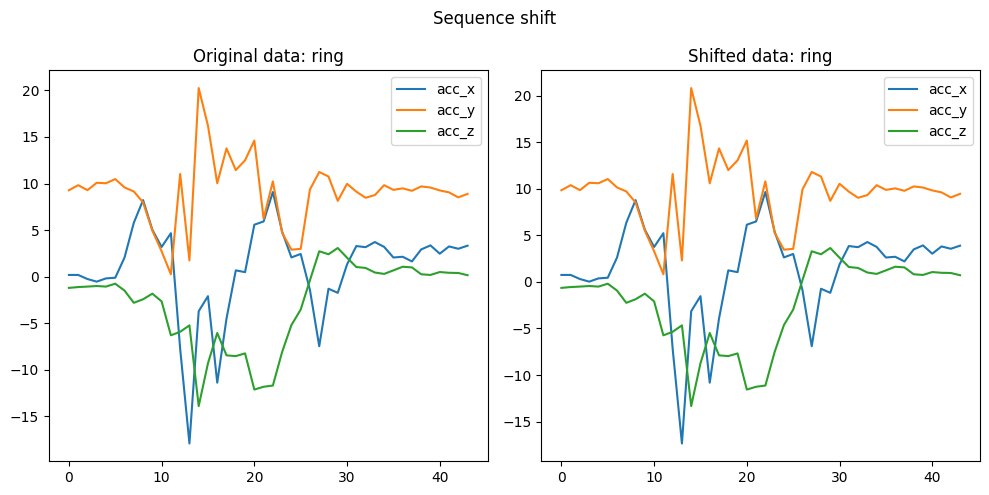

In [22]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axs[0].set_title("Original data: " + new_label[0])
axs[0].plot(acc_orig[0],label="acc_x")
axs[0].plot(acc_orig[1],label="acc_y")
axs[0].plot(acc_orig[2],label="acc_z")
axs[0].legend()

axs[1].set_title("Shifted data: " + new_label[0])
axs[1].plot(acc_mod[0],label="acc_x")
axs[1].plot(acc_mod[1],label="acc_y")
axs[1].plot(acc_mod[2],label="acc_z")
axs[1].legend()
fig.suptitle("Sequence shift")
plt.tight_layout()

Observe the very slight shift (by 0.558) upwards

### Random noise
A different random number is added to each value in the dataset

In [23]:
# Random noise
my_data = data[0]
my_label = copy.copy(labels[0])
new_data = []
new_label = []

new_data.append(my_data)
new_label.append(my_label)

random.seed(42)  ## only for test
random_values = []

# print("Length of tmp_data: ",len(tmp_data))
for num in range(5):
    tmp_data =[[0]*3 for i in range(len(my_data))]
    r = [] # some random data
    
    for i in range(len(my_data)):
        for j in range(3):
            r.append(random.random())
            tmp_data[i][j] = my_data[i][j] + 5 * r[3*i+j] # add random noise to each element in the data array

    random_values.append(r)  # keep the random values for this dataset
    new_data.append(tmp_data)
    new_label.append(my_label)

print("First 3 entries in tmp_data")
print("random values to add: {:4.2f}, {:4.2f}, {:4.2f}".format(5*random_values[0][0],5*random_values[0][1],5*random_values[0][2]))
print("new_data[0][0][0] .. new_data[0][0][2]: {:4.2f}, {:4.2f}, {:4.2f}".format(new_data[0][0][0],new_data[0][0][1],new_data[0][0][2]))
print("new_data[1][0][0] .. new_data[1][0][2]: {:4.2f}, {:4.2f}, {:4.2f}".format(new_data[1][0][0],new_data[1][0][1],new_data[1][0][2]))

First 3 entries in tmp_data
random values to add: 3.20, 0.13, 1.38
new_data[0][0][0] .. new_data[0][0][2]: 0.19, 9.28, -1.20
new_data[1][0][0] .. new_data[1][0][2]: 3.39, 9.41, 0.18


In [24]:
print("added:{:4.2f},{:4.2f},{:4.2f}, originals: {:4.2f},{:4.2f},{:4.2f}, new: {:4.2f},{:4.2f},{:4.2f}".
      format(5*random_values[0][0],5*random_values[0][1],5*random_values[0][2],
             new_data[0][0][0],new_data[0][0][1],new_data[0][0][2],
             new_data[1][0][0],new_data[1][0][1],new_data[1][0][2]))
                                                                                                            

added:3.20,0.13,1.38, originals: 0.19,9.28,-1.20, new: 3.39,9.41,0.18


In [25]:
print("new should be: {:4.2f},{:4.2f},{:4.2f}".format(new_data[0][0][0] + 5*random_values[0][0],
                                                      new_data[0][0][1] + 5*random_values[0][1],
                                                      new_data[0][0][2] + 5*random_values[0][2]))
                                                      

new should be: 3.39,9.41,0.18


In [26]:
print("Length of new data: ",len(new_data))

Length of new data:  6


In [27]:
acc_orig = (np.array(new_data[0])[:,0], 
        np.array(new_data[0])[:,1], 
        np.array(new_data[0])[:,2])
print("No of data points: ",len(acc_orig[0]))
acc_mod = (np.array(new_data[1])[:,0], 
        np.array(new_data[1])[:,1], 
        np.array(new_data[1])[:,2])

No of data points:  44


In [28]:
print(acc_mod[0][0] - acc_orig[0][0])

3.1971339922894186


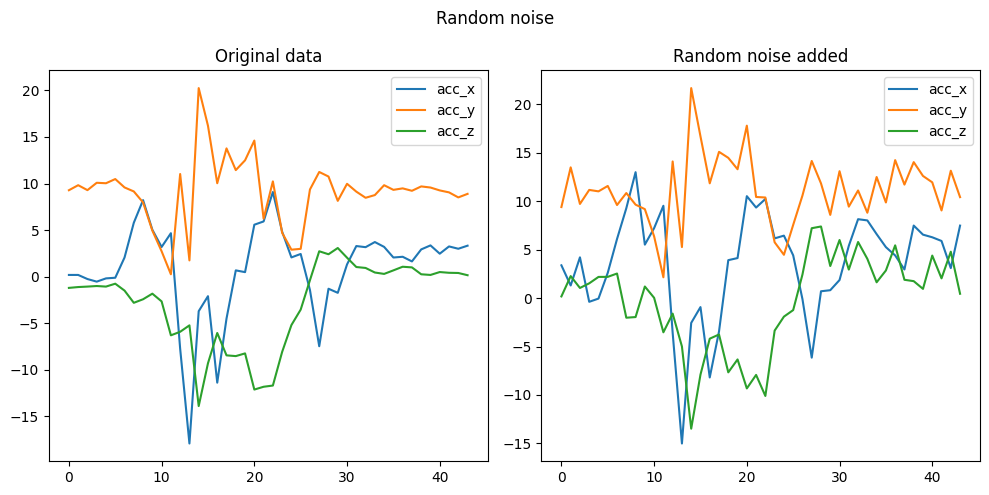

In [29]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axs[0].set_title("Original data")
axs[0].plot(acc_orig[0],label="acc_x")
axs[0].plot(acc_orig[1],label="acc_y")
axs[0].plot(acc_orig[2],label="acc_z")
axs[0].legend()

axs[1].set_title("Random noise added")
axs[1].plot(acc_mod[0],label="acc_x")
axs[1].plot(acc_mod[1],label="acc_y")
axs[1].plot(acc_mod[2],label="acc_z")
axs[1].legend()
fig.suptitle("Random noise")
plt.tight_layout()

### Time warping

In [30]:
fractions = [(3, 2), (5, 3), (2, 3), (3, 4), (9, 5), (6, 5), (4, 5)]
for molecule,denominator in fractions:
    print("molecule: {:d}, denominator: {:d}".format(molecule,denominator))

molecule: 3, denominator: 2
molecule: 5, denominator: 3
molecule: 2, denominator: 3
molecule: 3, denominator: 4
molecule: 9, denominator: 5
molecule: 6, denominator: 5
molecule: 4, denominator: 5


In [31]:
new_data = []
new_label = []
new_data.append(data[0])
new_label.append(labels[0])

for molecule, denominator in fractions:
    wrapped_data = time_wrapping(molecule, denominator, data[0])
    if len(wrapped_data) != 0:        
        new_data.append(wrapped_data)
        new_label.append(label)

In [32]:
print("No of data entries after time warping: ",len(new_data))

No of data entries after time warping:  8


In [33]:
acc_orig = (np.array(new_data[0])[:,0], 
        np.array(new_data[0])[:,1], 
        np.array(new_data[0])[:,2])
print("No of data points: ",len(acc_orig[0]))
acc_mod = (np.array(new_data[1])[:,0], 
        np.array(new_data[1])[:,1], 
        np.array(new_data[1])[:,2])

No of data points:  44


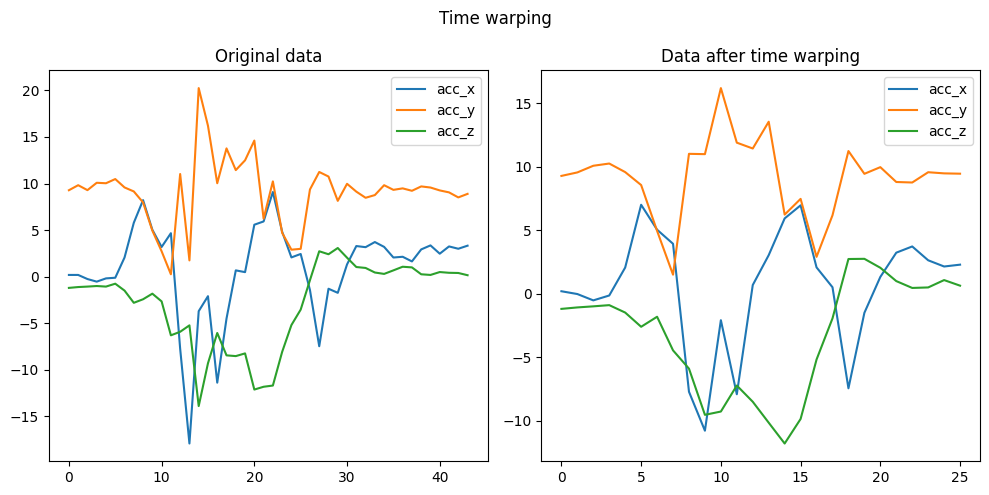

In [34]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axs[0].set_title("Original data")
axs[0].plot(acc_orig[0],label="acc_x")
axs[0].plot(acc_orig[1],label="acc_y")
axs[0].plot(acc_orig[2],label="acc_z")
axs[0].legend()

axs[1].set_title("Data after time warping")
axs[1].plot(acc_mod[0],label="acc_x")
axs[1].plot(acc_mod[1],label="acc_y")
axs[1].plot(acc_mod[2],label="acc_z")
axs[1].legend()
fig.suptitle("Time warping")
plt.tight_layout()

### Movement amplification

In [35]:
new_data = []
new_label = []
new_data.append(data[0])
new_label.append(labels[0])

for molecule, denominator in fractions:
    new_data.append(
        (np.array(new_data[0], dtype=np.float32) * molecule / denominator).tolist())
    new_label.append(label)
print("Length of new dataset: ",len(new_data))

Length of new dataset:  8


In [36]:
acc_orig = (np.array(new_data[0])[:,0], 
        np.array(new_data[0])[:,1], 
        np.array(new_data[0])[:,2])
print("No of data points: ",len(acc_orig[0]))
acc_mod = (np.array(new_data[1])[:,0], 
        np.array(new_data[1])[:,1], 
        np.array(new_data[1])[:,2])

No of data points:  44


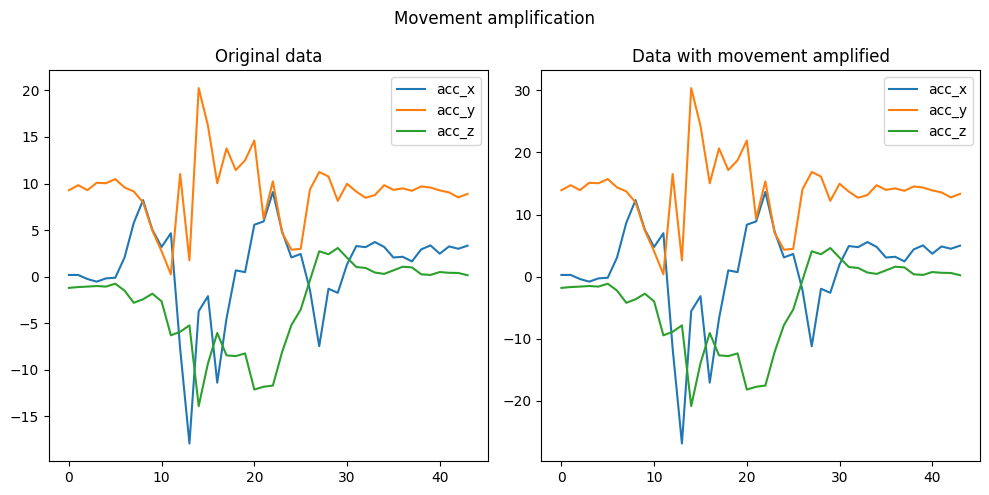

In [37]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axs[0].set_title("Original data")
axs[0].plot(acc_orig[0],label="acc_x")
axs[0].plot(acc_orig[1],label="acc_y")
axs[0].plot(acc_orig[2],label="acc_z")
axs[0].legend()

axs[1].set_title("Data with movement amplified")
axs[1].plot(acc_mod[0],label="acc_x")
axs[1].plot(acc_mod[1],label="acc_y")
axs[1].plot(acc_mod[2],label="acc_z")
axs[1].legend()
fig.suptitle("Movement amplification")
plt.tight_layout()

The total number of entries in the new (amplified) dataset is 2 * len(data) * 5 + 2 * len(data) * 7 + len(data)

In [38]:
print("Original data length: ",len(data))
total_length = len(data) + 2*5*len(data) + 2*7*len(data) - 2 # -2: skipped datasets when time warping 
print("Total length of amplified dataset: {:d}".format(total_length))

Original data length:  341
Total length of amplified dataset: 8523
